In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import ImageFilter, ImageEnhance
import random
import pandas as pd
import numpy as np
import json

In [2]:
# Make sure the GPU is being used
gpu_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.get_device_details(gpu_devices[0])

{'compute_capability': (8, 6), 'device_name': 'NVIDIA RTX A6000'}

In [3]:
cityscapes_dataset_path = '/notebooks/Cityscapes/'


# class_dict.csv path
classes_csv_path = "/notebooks/Cityscapes/class_dict.csv"

image_size = (256, 256)

In [4]:
cityscapes_validation_rgb = list(Path(cityscapes_dataset_path + 'Validation/RGB').glob('*.png'))
cityscapes_validation_annotated = list(Path(cityscapes_dataset_path + 'Validation/Annotated').glob('*.png'))
cityscapes_training_rgb = list(Path(cityscapes_dataset_path + 'Train/RGB').glob('*.png'))
cityscapes_training_annotated = list(Path(cityscapes_dataset_path + 'Train/Annotated').glob('*.png'))        


cityscapes_training_rgb.sort()
cityscapes_training_annotated.sort()
cityscapes_validation_rgb.sort()
cityscapes_validation_annotated.sort()
cityscapes_training_rgb = cityscapes_training_rgb
cityscapes_training_annotated = cityscapes_training_annotated
print('City Scapes Training Size: ' + str(len(cityscapes_training_rgb)))
print('City Scapes Validation Size: ' + str(len(cityscapes_validation_rgb)))

City Scapes Training Size: 2975
City Scapes Validation Size: 500


In [5]:
# Creates a list of tuples containing matching paths -> [(RGB image path, ANNOTATED image path), (..., ...), ...]
training_duo = [(x, y) for x, y in zip(cityscapes_training_rgb, cityscapes_training_annotated)]
validation_duo = [(x, y) for x, y in zip(cityscapes_validation_rgb, cityscapes_validation_annotated)]

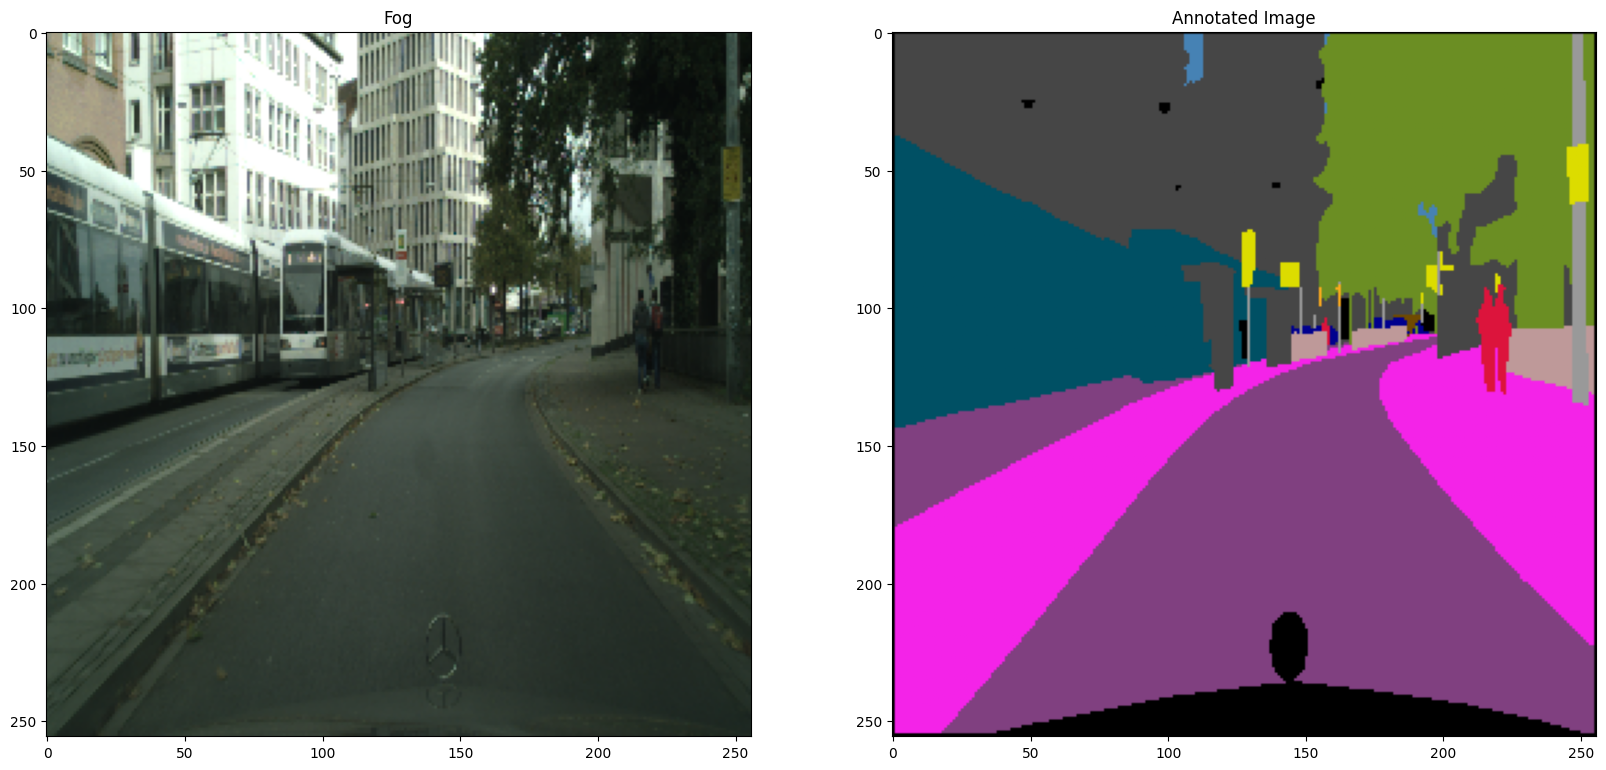

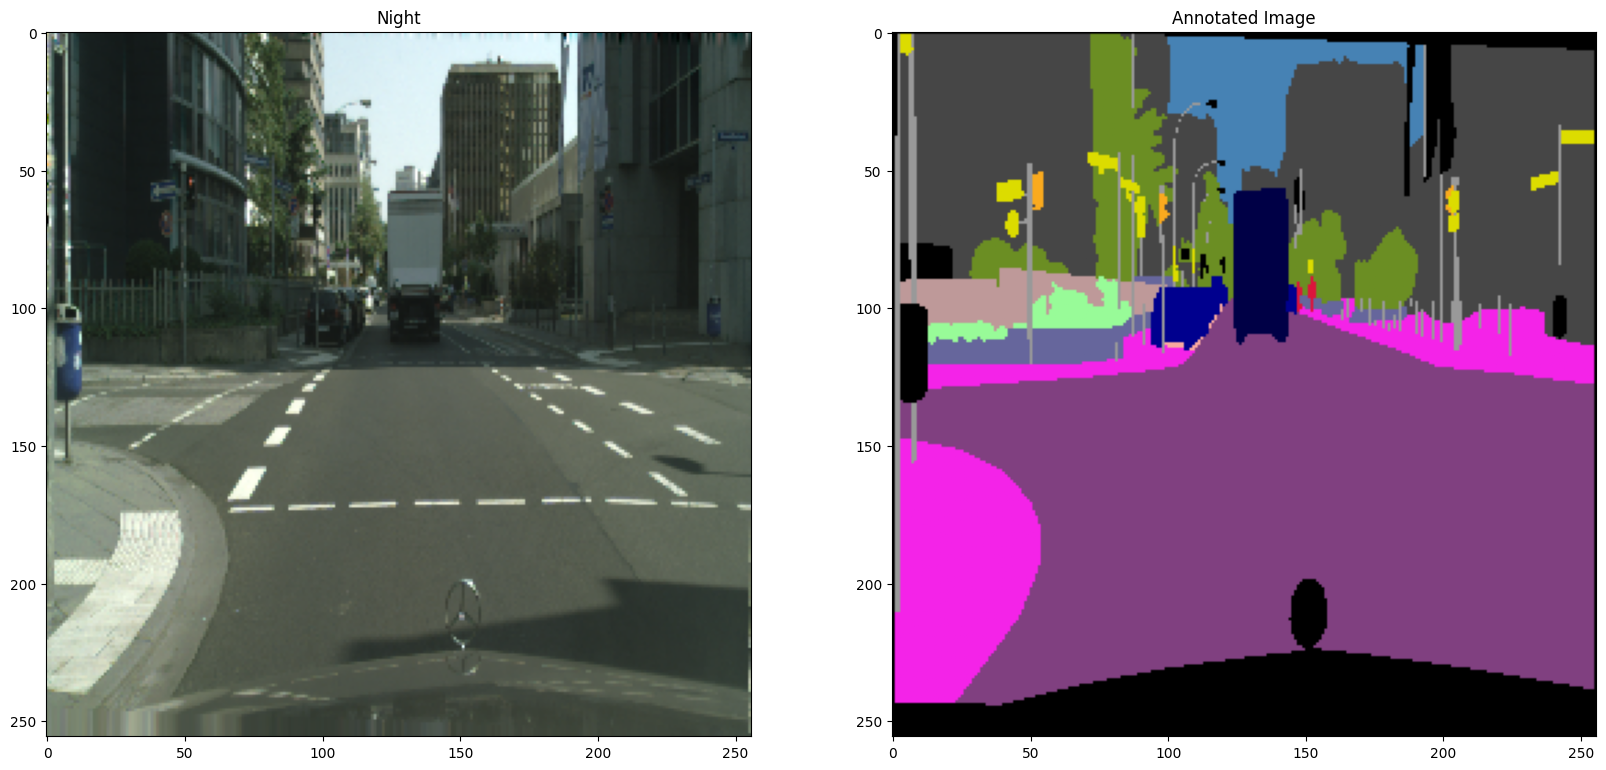

In [7]:
# Displays some images
# The RGB image with the corresponding ANNOTATED image should be correct

# Selects some images from the list of tuples
pictures = [training_duo[345], validation_duo[23]]

def show_sample(image, annotated_image, name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax1.set_title(name)
    ax1.imshow(image / 255.)
    ax2.set_title('Annotated Image')
    ax2.imshow(annotated_image / 255.)

count = 1

# Loop to print images in the order conditions from pictures: fog -> night -> rain -> snow
for x in pictures:
    image = img_to_array(load_img(x[0], target_size=image_size))
    annotated_image = img_to_array(load_img(x[1], target_size =image_size))
    if count == 1:
        show_sample(image, annotated_image, 'Fog')
    elif count == 2:
        show_sample(image, annotated_image, 'Night')
    elif count == 3:
        show_sample(image, annotated_image, 'Rain')
    else:
        show_sample(image, annotated_image, 'Snow')
    if count == 4:
        count = 1
    else:
        count += 1

In [6]:
# Loads list of classes with an array of RGB values -> [[R, G, B], [...,...,...], ...]
classes_df = pd.read_csv(classes_csv_path)
classes = []
class_labels = []

for index, item in classes_df.iterrows():
    classes.append(np.array([item['r'], item['g'], item['b']]))
    class_labels.append(item['name'])

num_classes = len(classes)

print('Number of Classes: ' + str(num_classes))
for x in classes:
    print(x)
    
for x in class_labels:
    print(x)

Number of Classes: 29
[0 0 0]
[111  74   0]
[81  0 81]
[128  64 128]
[244  35 232]
[250 170 160]
[230 150 140]
[70 70 70]
[102 102 156]
[190 153 153]
[180 165 180]
[150 100 100]
[150 120  90]
[153 153 153]
[250 170  30]
[220 220   0]
[107 142  35]
[152 251 152]
[ 70 130 180]
[220  20  60]
[255   0   0]
[  0   0 142]
[ 0  0 70]
[  0  60 100]
[ 0  0 90]
[  0   0 110]
[  0  80 100]
[  0   0 230]
[119  11  32]
unlabeled
dynamic
ground
road
sidewalk
parking
rail track
building
wall
fence
guard rail
bridge
tunnel
pole
traffic light
traffic sign
vegetation
terrain
sky
person
rider
car
truck
bus
caravan
trailer
train
motorcycle
bicycle


In [15]:
c = {tuple(k): v for k, v in zip(classes, class_labels)}

class_occurence = {}
for x in class_labels:
    class_occurence[x] = 0   
class_occurence
for image in validation_duo[:400]:
    label = load_img(image[1], target_size=(256, 256))
    label = img_to_array(label)
    data_reshaped  = label.reshape(-1, label.shape[-1])
    structured_data = data_reshaped.view([('', data_reshaped.dtype)] * data_reshaped.shape[1])
    unique_classes = np.unique(structured_data)
    for x in unique_classes:
        temp = tuple(np.asarray(x.tolist(), dtype = 'int'))
        try:
            class_occurence[c[temp]] = class_occurence[c[temp]] + 1 
        except:
            print('Not found' + str(temp))
            continue
class_occurence   

{'unlabeled': 400,
 'dynamic': 209,
 'ground': 159,
 'road': 386,
 'sidewalk': 368,
 'parking': 90,
 'rail track': 15,
 'building': 394,
 'wall': 165,
 'fence': 157,
 'guard rail': 1,
 'bridge': 11,
 'tunnel': 0,
 'pole': 390,
 'traffic light': 238,
 'traffic sign': 377,
 'vegetation': 393,
 'terrain': 182,
 'sky': 349,
 'person': 329,
 'rider': 188,
 'car': 381,
 'truck': 62,
 'bus': 58,
 'caravan': 4,
 'trailer': 4,
 'train': 22,
 'motorcycle': 80,
 'bicycle': 258}

In [7]:
import albumentations as A

def strong_aug(p=0.5):
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.25),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.5),
        A.CLAHE(clip_limit=(1,4), p=0.5),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1)
        ], p=0.2),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0),p=0.1),
            A.GaussianBlur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ], p=p, additional_targets={"image2" : "image"})

# Converts annotations from RGB to 2D -> Array of size image_size x image_size which contains each pixel -> Each pixel will hold a class value
def rgb_to_2D_classes(annotated, class_map):
    label = np.zeros(annotated.shape[:2], dtype=np.uint8)
    for i, rgb in enumerate(class_map):
        label[(annotated == rgb).all(axis=2)] = i
    return label

# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, duo, classes, n_classes, batch_size=4, dim=(128, 128), shuffle=True, train_set = False):
        'Initialization'
        self.dim = dim
        self.duo = duo
        self.classes = classes
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.train_set = train_set
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.duo) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.duo))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []

        # Generate data
        # Could use albumentations library for augmentations (see below cell)
        for i in list_IDs_temp:
            # Store sample
            original_image = load_img(self.duo[i][0], target_size=self.dim)
            img = img_to_array(original_image) / 255. # Image to numpy array -> / 255. to get array values between 0 and 1
            X.append(img)
            
            label = load_img(self.duo[i][1], target_size=self.dim)
            label = img_to_array(label)
            label = rgb_to_2D_classes(label, self.classes)
            label = to_categorical(label, num_classes=self.n_classes) # Converts to binary class matrix
            y.append(label)
            
            if self.train_set and random.choice([True, False]):
                # for x in range (0,1):
                image1 = img_to_array(load_img(self.duo[i][0], target_size=self.dim)).astype(np.uint8)
                image2 = img_to_array(load_img(self.duo[i][1], target_size=self.dim)).astype(np.uint8)
                aug_input = {"image" : image1, "image2" : image2}
                aug = strong_aug(1)
                augmented_data = aug(**aug_input)
                i1 = augmented_data["image"] / 255.
                i2 = augmented_data["image2"]
                i2 = rgb_to_2D_classes(i2, self.classes)
                i2 = to_categorical(i2, num_classes=self.n_classes) # Converts to binary class matrix
                X.append(i1)
                y.append(i2)
                
        return np.array(X), np.array(y)

In [8]:
from keras.regularizers import l2

# U-Net model class
class UNet:
    def __init__(self, dimensions, channels, filters, n_classes, weight_decay=1e-4):
        input_layer = Input(shape=(dimensions + (channels,)), name='input')

        conv_1_layer = self.__gen_convolution(input_layer, filters, weight_decay)
        conv_1_pooling = MaxPooling2D(pool_size=(2, 2))(conv_1_layer)

        conv_2_layer = self.__gen_convolution(conv_1_pooling, filters * 2, weight_decay)
        conv_2_pooling = MaxPooling2D(pool_size=(2, 2))(conv_2_layer)

        conv_3_layer = self.__gen_convolution(conv_2_pooling, filters * 4, weight_decay)
        conv_3_pooling = MaxPooling2D(pool_size=(2, 2))(conv_3_layer)

        conv_4_layer = self.__gen_convolution(conv_3_pooling, filters * 8, weight_decay)
        conv_4_pooling = MaxPooling2D(pool_size=(2, 2))(conv_4_layer)

        conv_5_layer = self.__gen_convolution(conv_4_pooling, filters * 16, weight_decay)

        deconv_6_layer = self.__gen_deconvolution(conv_5_layer, filters * 8, conv_4_layer, weight_decay)

        deconv_7_layer = self.__gen_deconvolution(deconv_6_layer, filters * 4, conv_3_layer, weight_decay)

        deconv_8_layer = self.__gen_deconvolution(deconv_7_layer, filters * 2, conv_2_layer, weight_decay)
        
        deconv_9_layer = self.__gen_deconvolution(deconv_8_layer, filters * 2, conv_1_layer, weight_decay)
        
        output_layer = Conv2D(filters=n_classes, kernel_size=(1, 1), activation='softmax')(deconv_9_layer)

        self.model = Model(inputs=input_layer, outputs=output_layer, name='UNet')

    def __gen_convolution(self, prev, filters, weight_decay):
        temp = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',
                         activation='relu', kernel_regularizer=l2(weight_decay))(prev)
        temp = BatchNormalization()(temp)
        temp = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',
                         activation='relu', kernel_regularizer=l2(weight_decay))(temp)
        return BatchNormalization()(temp)

    def __gen_deconvolution(self, prev, filters, residual, weight_decay):
        temp = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same', 
                               kernel_regularizer=l2(weight_decay))(prev)
        temp = concatenate([temp, residual], axis=3)
        return self.__gen_convolution(temp, filters, weight_decay)

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Let's first define the Convolutional Block that will be used in the model
def conv_block(tensor, num_filters):
    tensor = Conv2D(num_filters, (3, 3), padding="same")(tensor)
    tensor = tf.keras.layers.BatchNormalization()(tensor)
    tensor = tf.keras.layers.Activation("relu")(tensor)
    tensor = Conv2D(num_filters, (3, 3), padding="same")(tensor)
    tensor = tf.keras.layers.BatchNormalization()(tensor)
    tensor = tf.keras.layers.Activation("relu")(tensor)
    return tensor

# Let's define the model
def UNetPlusPlus(input_shape, num_classes):
    # Encoder
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False # Freeze layers in the encoder

    skip_connections = ['conv2_block3_out', 'conv3_block4_out', 'conv4_block23_out', 'conv5_block3_out']
    encoder_layers = [base_model.get_layer(name).output for name in skip_connections]

    # Use the Functional API to create the encoder model
    encoder = Model(inputs=base_model.input, outputs=encoder_layers, name='Encoder')
    
    # Decoder
    init = Input(input_shape)
    x = init
    skips = encoder(x)
    
    x = conv_block(skips[3], 256)
    x0_1 = conv_block(concatenate([UpSampling2D()(x), skips[2]]), 256)

    x = conv_block(concatenate([x, x0_1]), 512)
    x1_0 = conv_block(concatenate([UpSampling2D()(x), skips[1]]), 512)
    x0_2 = conv_block(concatenate([UpSampling2D()(x1_0), x0_1, skips[2]]), 256)

    x = conv_block(concatenate([x, x1_0]), 1024)
    x2_0 = conv_block(concatenate([UpSampling2D()(x), skips[0]]), 1024)
    x1_1 = conv_block(concatenate([UpSampling2D()(x2_0), x1_0, skips[1]]), 512)
    x0_3 = conv_block(concatenate([UpSampling2D()(x1_1), x0_2, x0_1, skips[2]]), 256)

    x = conv_block(concatenate([x, x2_0, x1_1, x0_3]), 2048)

    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    return Model(init, x)


In [13]:
from keras_unet_collection import models, utils

#model = UNet(image_size, 3, 64, num_classes).model
# model = models.unet_plus_2d((256, 256, 3), [64, 128, 256, 512], n_labels=num_classes,
#                             stack_num_down=2, stack_num_up=2,
#                             activation='ReLU', output_activation='Softmax', 
#                             batch_norm=True, pool='max', unpool=False, backbone='ResNet101', weights='imagenet', 
#                             freeze_backbone=False, name='UNetPlusPlus')
model = models.unet_plus_2d((256, 256, 3), 
                  filter_num=[64, 128, 256, 512, 1024], 
                  n_labels=num_classes,
                  stack_num_down=2, 
                  stack_num_up=2,
                  activation='ReLU', 
                  batch_norm=True, 
                  pool=True, 
                  unpool=True, 
                  deep_supervision=True, 
                  backbone='ResNet101', 
                  weights='imagenet', 
                  freeze_backbone=True, 
                  name='unet_plus')
model.load_weights('/notebooks/cityscapes/cityscapes-weight.h5')
model.compile(optimizer='adamax', loss='categorical_crossentropy' ,metrics=['accuracy', keras.metrics.OneHotMeanIoU(num_classes=num_classes)])
model.summary()
                            

----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet_plus_output_sup0_activation
	unet_plus_output_sup1_activation
	unet_plus_output_sup2_activation
	unet_plus_output_final_activation
Model: "unet_plus_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 ResNet101_backbone (Functional  [(None, 128, 128, 6  27659648   ['input_4[0][0]']                
 )                              4),                                              

In [14]:
model_my_callbacks = [
    CSVLogger("./cityscapes/logs/log-2.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./cityscapes/cityscapes-weight-2.h5', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
    TensorBoard(log_dir='./cityscapes/logs-2')
]

training_data = DataGenerator(training_duo,classes,num_classes,batch_size=32, dim=image_size ,shuffle=True, train_set=True)
training_steps = training_data.__len__()

validation_data = DataGenerator(validation_duo,classes,num_classes,batch_size=32, dim=image_size ,shuffle=True)
validation_steps = validation_data.__len__()


In [ ]:
history = model.fit(training_data, epochs=1000, callbacks=model_my_callbacks, validation_data=validation_data, steps_per_epoch=training_steps, validation_steps=validation_steps)

/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Epoch 1/1000
18/92 [====>.........................] - ETA: 8:58 - loss: 4.1653 - unet_plus_output_sup0_activation_loss: 0.8677 - unet_plus_output_sup1_activation_loss: 0.9820 - unet_plus_output_sup2_activation_loss: 1.1320 - unet_plus_output_final_activation_loss: 1.1835 - unet_plus_output_sup0_activation_accuracy: 0.7589 - unet_plus_output_sup0_activation_one_hot_mean_io_u: 0.1262 - unet_plus_output_sup1_activation_accuracy: 0.7294 - unet_plus_output_sup1_activation_one_hot_mean_io_u: 0.1123 - unet_plus_output_sup2_activation_accuracy: 0.6544 - unet_plus_output_sup2_activation_one_hot_mean_io_u: 0.0842 - unet_plus_output_final_activation_accuracy: 0.6501 - unet_plus_output_final_activation_one_hot_mean_io_u: 0.0781

In [16]:
class Predict:
    def __init__(self, image_size, model, classes):
        self.image_size = image_size
        self.model = model
        self.classes = classes

    # image_path_pair = (Image Path, Annotated Path)
    def predict(self, image_path_pair):
        image = img_to_array(load_img(image_path_pair[0] , target_size=self.image_size))
        annotated_image = img_to_array(load_img(image_path_pair[1], target_size=self.image_size))

        image_expanded = np.expand_dims(img_to_array(load_img(image_path_pair[0], target_size=self.image_size)) / 255., axis=0)
        prediction = np.argmax(self.model.predict(image_expanded)[0], axis=2)
        prediction_colored = np.array(self.classes)[prediction].astype(np.uint8)
        self.__plot(image, annotated_image, prediction_colored)

    def __plot(self, image, annotated_image, prediction):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_figheight(20)
        fig.set_figwidth(20)
        ax1.set_title('Image')
        ax1.imshow(image / 255.)
        ax2.set_title('Annotated Image')
        ax2.imshow(annotated_image / 255.)
        ax3.set_title('Prediction')
        ax3.imshow(prediction / 255.)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')

In [33]:
prediction = Predict(image_size, model, classes)

1/1 [==============================] - 0s 17ms/step


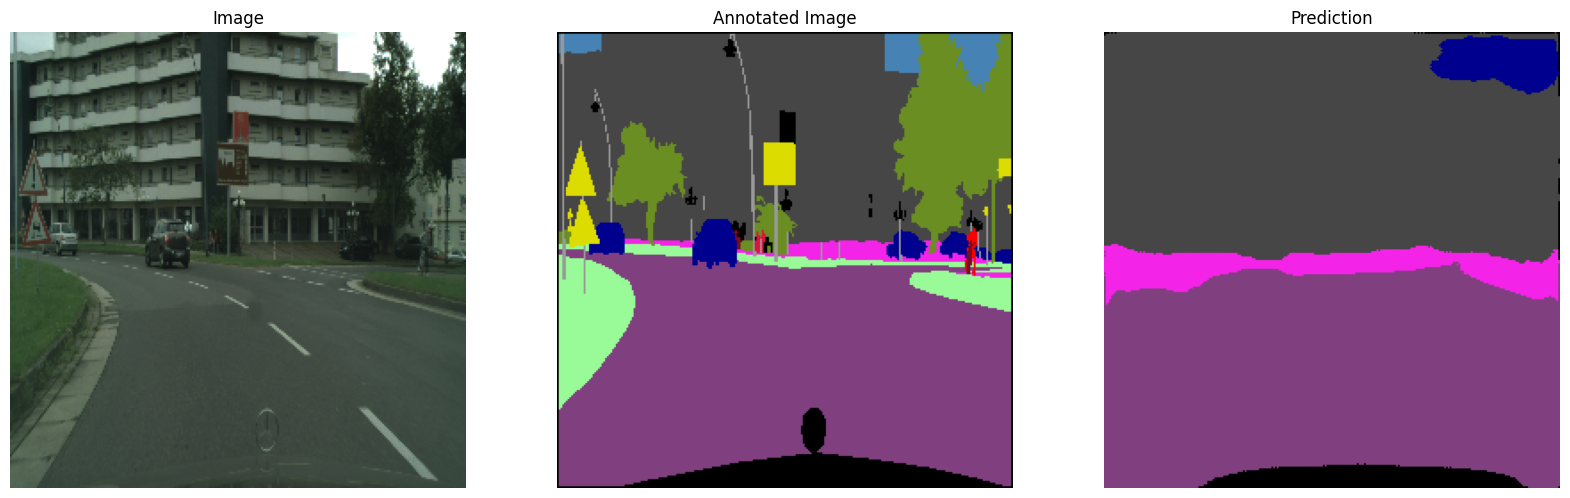

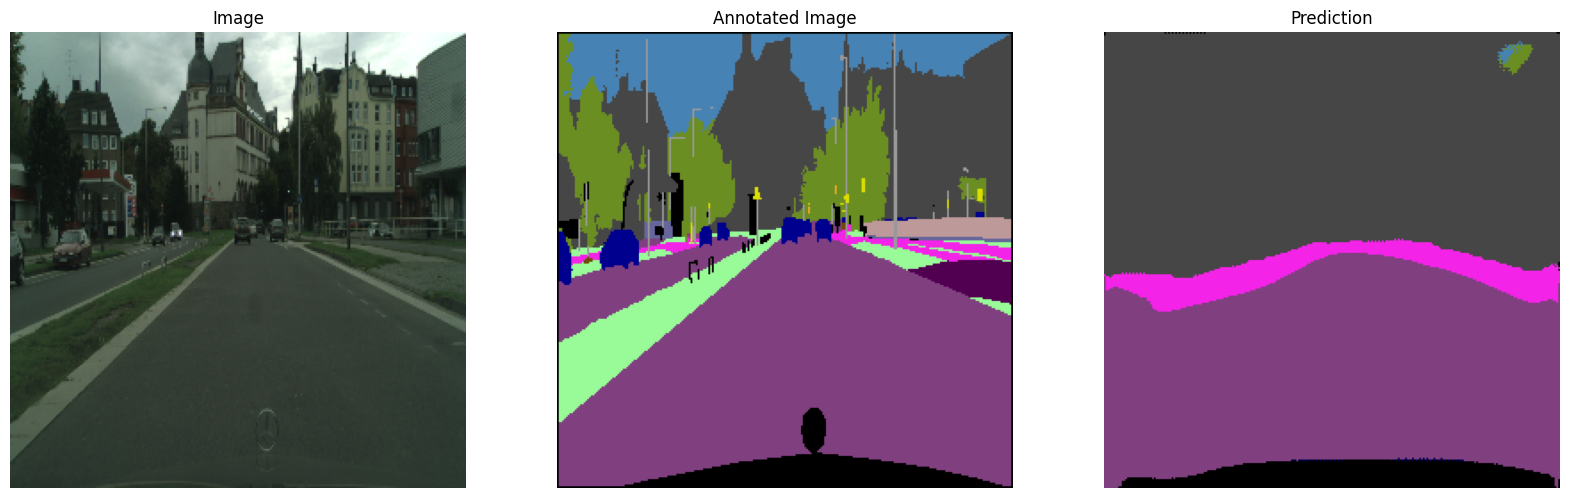

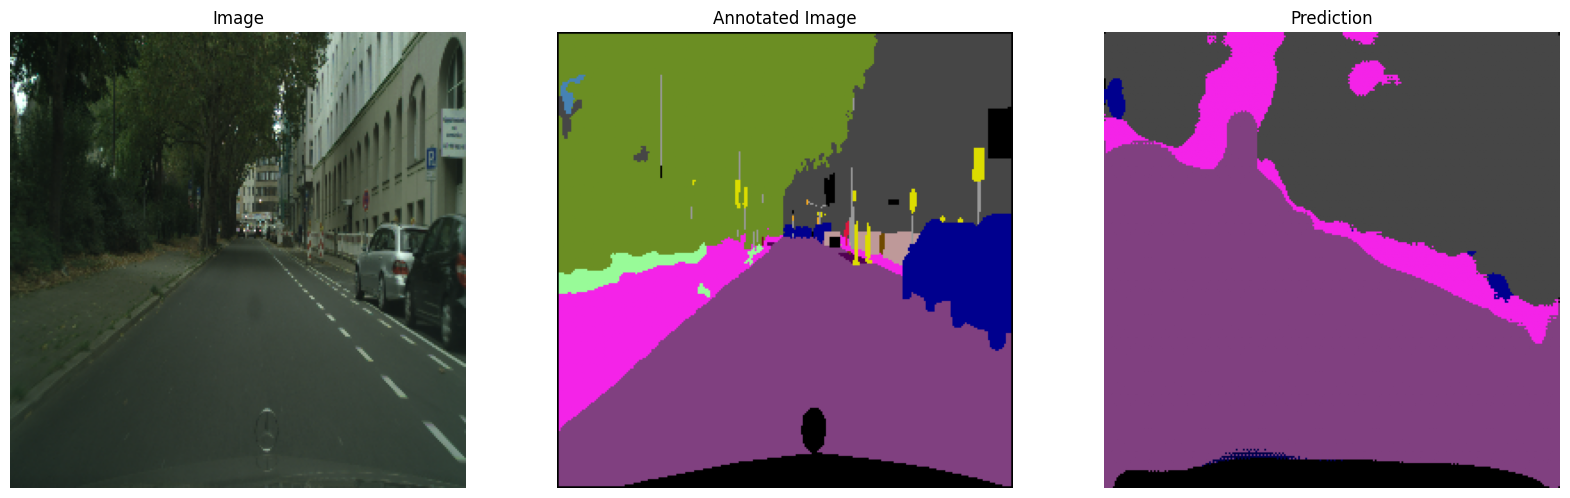

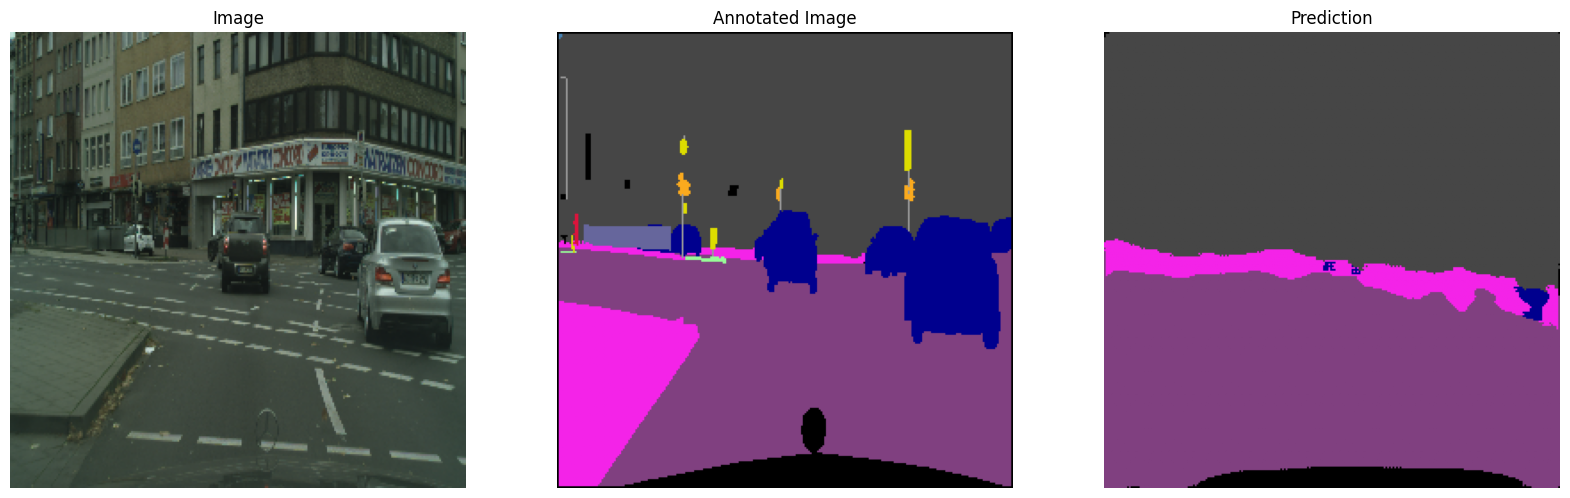

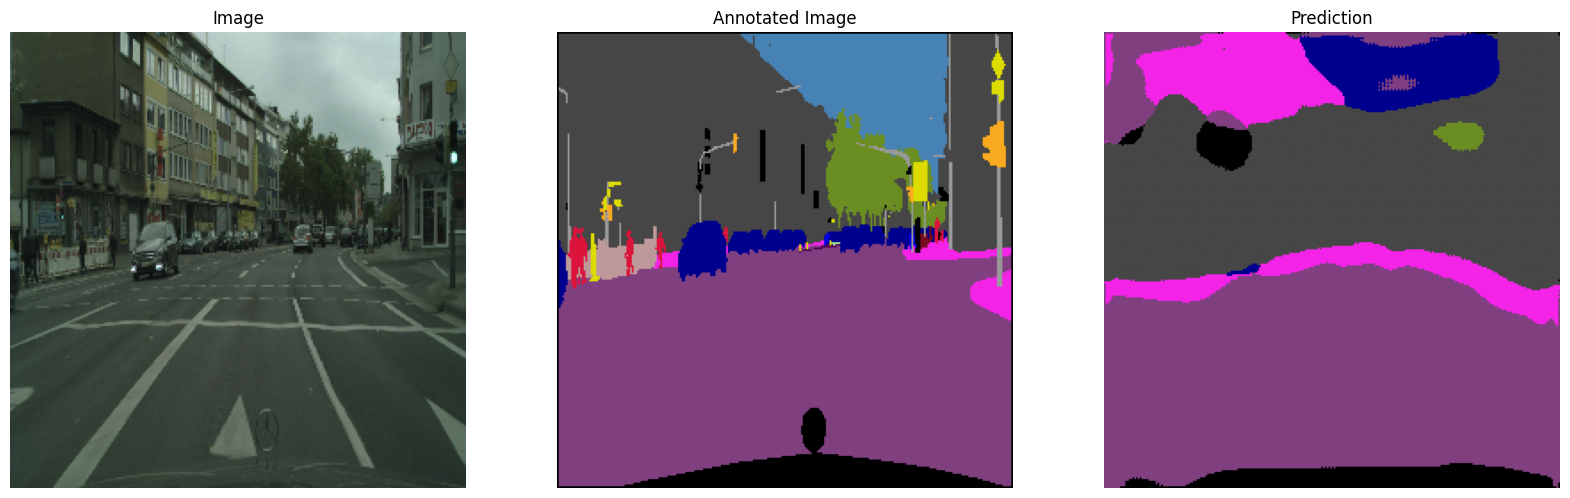

In [34]:
for x in range(0, 5):
    prediction.predict(training_duo[x])